## Build an MTH5 and Operate the Aurora Pipeline

This notebook pulls MT miniSEED data from the IRIS Dataselect web service and produces MTH5 out of it. It outlines the process of making an MTH5 file, generating a processing config, and running the Aurora processor.

It assumes that aurora, mth5, and mt_metadata have all been installed.

In this "new" version, the workflow has changed somewhat.  

1. The process_mth5 call works with a dataset dataframe, rather than a single run_id
2. The config object is now based on the mt_metadata.base Base class
3. Remote reference processing is supported (at least in theory)

### Flow of this notebook

Section 1: Here we do imports and construct a table of the data that we will access to build the mth5.  Note that there is no explanation here as to the table source -- a future update can show how to create such a table from IRIS data_availability tools

Seciton 2: the metadata and the data are accessed, and the mth5 is created and stored.

Section 3: Aurora is used to process the data

In [1]:
# Use this for developing
%load_ext autoreload
%autoreload 2


In [2]:
# Required imports for the program. 
from pathlib import Path
import pandas as pd
import warnings

from mth5.clients.make_mth5 import MakeMTH5
from mth5 import mth5, timeseries
from mth5.utils.helpers import initialize_mth5
from mt_metadata.utils.mttime import get_now_utc, MTime
from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.transfer_function.kernel_dataset import KernelDataset
from aurora.pipelines.run_summary import RunSummary

warnings.filterwarnings('ignore')

2022-09-09 02:14:57,256 [line 135] mth5.setup_logger - INFO: Logging file can be found /home/kkappler/software/irismt/mth5/logs/mth5_debug.log


## Build an MTH5 file from information extracted by IRIS


Set path so MTH5 file builds to current working directory. 

In [3]:
default_path = Path().cwd()
default_path

PosixPath('/home/kkappler/software/irismt/aurora/docs/examples')

Select mth5 file version

In [4]:
# mth5_version = '0.1.0'
mth5_version = '0.2.0'


In [5]:
# Initialize the Make MTH5 code. 
m = MakeMTH5(mth5_version=mth5_version)
m.client = "IRIS"

### Specify the data to access from IRIS

Note that here we explicitly prescribe the data, but this dataframe could be built from IRIS data availability tools in a programatic way

In [6]:
# Generate data frame of FDSN Network, Station, Location, Channel, Startime, Endtime codes of interest

CAS04LQE = ['8P', 'CAS04', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04LQN = ['8P', 'CAS04', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFE = ['8P', 'CAS04', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFN = ['8P', 'CAS04', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFZ = ['8P', 'CAS04', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']

request_list = [CAS04LQE, CAS04LQN, CAS04BFE, CAS04BFN, CAS04BFZ]

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=m.column_names)

In [7]:
# Inspect the dataframe
print(request_df)

  network station location channel                start                  end
0      8P   CAS04              LQE  2020-06-02T19:00:00  2020-07-13T19:00:00
1      8P   CAS04              LQN  2020-06-02T19:00:00  2020-07-13T19:00:00
2      8P   CAS04              LFE  2020-06-02T19:00:00  2020-07-13T19:00:00
3      8P   CAS04              LFN  2020-06-02T19:00:00  2020-07-13T19:00:00
4      8P   CAS04              LFZ  2020-06-02T19:00:00  2020-07-13T19:00:00


In [8]:
# Request the inventory information from IRIS
inventory = m.get_inventory_from_df(request_df, data=False)

In [9]:
# Inspect the inventory
inventory

(Inventory created at 2022-09-09T09:15:07.864985Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (1):
			8P.CAS04 (Corral Hollow, CA, USA)
		Channels (8):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN (2x), 
			8P.CAS04..LQE (3x),
 0 Trace(s) in Stream:
)

Builds an MTH5 file from the user defined database. 

With the mth5 object set, we are ready to actually request the data from the fdsn client (IRIS) and save it to an MTH5 file.  This process builds an MTH5 file and can take some time depending on how much data is requested.  

Note: `interact` keeps the MTH5 open after it is done building


In [10]:
interact = True
mth5_object = m.make_mth5_from_fdsnclient(request_df, interact=interact)

2022-09-09 02:15:20,020 [line 597] mth5.mth5.MTH5.open_mth5 - WARNING: 8P_CAS04.h5 will be overwritten in 'w' mode
2022-09-09 02:15:20,440 [line 664] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file /home/kkappler/software/irismt/aurora/docs/examples/8P_CAS04.h5 in mode w
2022-09-09 02:18:14,616 [line 121] mt_metadata.base.metadata.station.add_run - WARNING: Run a is being overwritten with current information


2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-09-09T02:18:14 [line 136] obspy_stages.create_filter_from_stage - IN

2022-09-09 02:18:17,113 [line 746] mth5.groups.base.Station.add_run - INFO: run a already exists, returning existing group.
2022-09-09 02:18:17,405 [line 224] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2020-06-02T19:00:00+00:00 does not match metadata start 2020-06-02T18:41:43+00:00 updating metatdata value to 2020-06-02T19:00:00+00:00
2022-09-09 02:18:24,659 [line 746] mth5.groups.base.Station.add_run - INFO: run b already exists, returning existing group.
2022-09-09 02:18:34,050 [line 746] mth5.groups.base.Station.add_run - INFO: run c already exists, returning existing group.
2022-09-09 02:18:45,149 [line 746] mth5.groups.base.Station.add_run - INFO: run d already exists, returning existing group.
2022-09-09 02:18:46,420 [line 235] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-07-13T19:00:00+00:00 does not match metadata end 2020-07-13T21:46:12+00:00 updating metatdata value to 2020-07-13T19:00:00+00:00


### Examine and Update the MTH5 object

With the open MTH5 Object, we can start to examine what is in it. For example, retrieve the filename and file_version. You can additionally do things such as getting the station information and edit it by setting a new value, in this case the declination model. 

In [11]:
mth5_path = mth5_object.filename

In [12]:
mth5_object

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: CONUS_South
            ---------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: electric_analog_to_digital
                        ------------------------------------
                        |- Group: electric_dipole_92.000
                        --------------------------------
                        |- Group: electric_si_units
                        ---------------------------
                        |- Group: magnetic_analog_to_digital
                        ------------------------------------
                    |- Group: fap
   

In [13]:
mth5_object.file_version


'0.2.0'

In [14]:
mth5_object.close_mth5()

2022-09-09 02:20:13,274 [line 739] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/docs/examples/8P_CAS04.h5


In [15]:
mth5_object = initialize_mth5(mth5_path)

### Need documentation:
Is the cell below required? Or is it an example of some metadata specification?

In [16]:
# Edit and update the MTH5 metadata 
s = mth5_object.get_station("CAS04", survey="CONUS_South")
print(s.metadata.location.declination.model)
s.metadata.location.declination.model = 'IGRF'
print(s.metadata.location.declination.model)
s.write_metadata()    # writes to file mth5_filename

IGRF-13
IGRF


In [17]:
# Print some info about the mth5 
mth5_filename = mth5_object.filename
version = mth5_object.file_version
print(f" Filename: {mth5_filename} \n Version: {version}")


 Filename: /home/kkappler/software/irismt/aurora/docs/examples/8P_CAS04.h5 
 Version: 0.2.0


In [18]:
# Get the available stations and runs from the MTH5 object
mth5_object.channel_summary.summarize()
ch_summary = mth5_object.channel_summary.to_dataframe()

## If MTH5 file already exists you can start here
If you dont want to execute the previous code to get data again

In [19]:
interact = False
if interact:
    pass
else:
    h5_path = default_path.joinpath("8P_CAS04.h5")
    mth5_object = initialize_mth5(h5_path, mode="a", file_version=mth5_version)
    ch_summary = mth5_object.channel_summary.to_dataframe()



### Generate an Aurora Configuration file using MTH5 as an input

Up to this point, we have used mth5 and mt_metadata, but haven't yet used aurora. So we will use the MTH5 that we just created (and examined and updated) as input into Aurora.



### Channel Summary

This is a very useful datastructure inside the mth5.   It acts basically like an index of available data at the channel-run level, i.e. there is one row for every contiguous chunk of time-series recorded by an electric dipole or magnetometer

In [20]:
ch_summary

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


The Channel summary has a lot of uses, below we use it to check if the data have mixed sample rates, and to get a list of available stations

In [21]:
available_runs = ch_summary.run.unique()
sr = ch_summary.sample_rate.unique()
if len(sr) != 1:
    print('Only one sample rate per run is available')
    
available_stations = ch_summary.station.unique()
print(f"Available stations: {available_stations}")

Available stations: ['CAS04']


### Run Summary

A cousin of the channel summary is the Run Summary.
This is a condensed version of the channel summary, with one row per continuous acquistion run at a station.

The run summary can be accessed from an open mth5 object as in the example below


### Now, we condense the channel summary into a run_summary.

This method takes an iterable of mth5_objs or h5_paths

Or it can be accessed by pointing at a file:


In [22]:
mth5_run_summary = RunSummary()
h5_path = default_path.joinpath("8P_CAS04.h5")
mth5_run_summary.from_mth5s([h5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2022-09-09 02:21:12,671 [line 739] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/docs/examples/8P_CAS04.h5


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,mth5_path
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/exa...
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/exa...
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/exa...
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",/home/kkappler/software/irismt/aurora/docs/exa...


Now we have a dataframe of the available runs to process from the MTH5 

Here are the columns available in the run summary

### If the mth5 file is closed, you can get the run summary this way

### Here are the columns to look at to get a sense of the data coverage

Sometimes we just want to look at the survey, station, run, and time intervals
we can for that we can call mini_summary

In [23]:
run_summary.mini_summary

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### Kernel Dataset

This is like a run summary, but for a single station or a pair of stations.
It is used to specify the inputs to aurora processing.

It takes a run_summary and a station name, and optionally, a remote reference station name

It is made _based on the available data_.

Syntax is kernel_dataset.from_run_summary(run_summary, local_station_id, reference_station_id)

### Here are the columns in the run summary

By Default, all runs will be processed

To restrict to processing a single run, or a list of runs, we can either tell KernelDataset to keep or drop a station_run dictionary. 


To restrict to processing a single run, or a list of runs, we can either tell KernelDataset to keep or drop a station_run dictionary. 


In [24]:
print(run_summary.df.columns)

Index(['survey', 'station_id', 'run_id', 'start', 'end', 'sample_rate',
       'input_channels', 'output_channels', 'channel_scale_factors',
       'mth5_path'],
      dtype='object')


In [25]:
coverage_short_list_columns = ['station_id', 'run_id', 'start', 'end', ]
print(run_summary.df[coverage_short_list_columns])

  station_id run_id                     start                       end
0      CAS04      a 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00
1      CAS04      b 2020-06-02 22:24:55+00:00 2020-06-12 17:52:23+00:00
2      CAS04      c 2020-06-12 18:32:17+00:00 2020-07-01 17:32:59+00:00
3      CAS04      d 2020-07-01 19:36:55+00:00 2020-07-13 19:00:00+00:00


In [26]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


## Here is one way to select a single run:


In [27]:
station_runs_dict = {}
station_runs_dict["CAS04"] = ["a", ]
keep_or_drop = "keep"

kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
print(kernel_dataset.df[coverage_short_list_columns])

  station_id run_id                     start                       end
0      CAS04      a 2020-06-02 19:00:00+00:00 2020-06-02 22:07:46+00:00


## To discard runs that are not very long

In [28]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
cutoff_duration_in_seconds = 15000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
print(kernel_dataset.df[coverage_short_list_columns])

  station_id run_id                     start                       end
0      CAS04      b 2020-06-02 22:24:55+00:00 2020-06-12 17:52:23+00:00
1      CAS04      c 2020-06-12 18:32:17+00:00 2020-07-01 17:32:59+00:00
2      CAS04      d 2020-07-01 19:36:55+00:00 2020-07-13 19:00:00+00:00


### Select only runs "b" & "d"

In [29]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
station_runs_dict = {}
station_runs_dict["CAS04"] = ["b","d"]
keep_or_drop = "keep"
kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
print(kernel_dataset.df[coverage_short_list_columns])

  station_id run_id                     start                       end
0      CAS04      b 2020-06-02 22:24:55+00:00 2020-06-12 17:52:23+00:00
1      CAS04      d 2020-07-01 19:36:55+00:00 2020-07-13 19:00:00+00:00


### The same result can be obtained by _excluding_ runs a & c

In [30]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
station_runs_dict = {}
station_runs_dict["CAS04"] = ["a","c"]
keep_or_drop = "drop"
kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
print(kernel_dataset.df[coverage_short_list_columns])

  station_id run_id                     start                       end
0      CAS04      b 2020-06-02 22:24:55+00:00 2020-06-12 17:52:23+00:00
1      CAS04      d 2020-07-01 19:36:55+00:00 2020-07-13 19:00:00+00:00


Make an aurora configuration file (and then save that json file.)

In [31]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset, 
                                       emtf_band_file=BANDS_DEFAULT_FILE,)


In [32]:
for decimation in config.decimations:
    decimation.estimator.engine = "RME"

Take a look at the config:

In [33]:
config

{
    "processing": {
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "decimation_level": 0,
                                "frequency_max": 0,
                                "frequency_min": 0,
                                "index_max": 30,
                                "index_min": 25
                            }
                        },
                        {
                            "band": {
                                "decimation_level": 0,
                                "frequency_max": 0,
                                "frequency_min": 0,
             

Run the Aurora Pipeline using the input MTh5 and Confiugration File

Processing config indicates 4 decimation levels 
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s


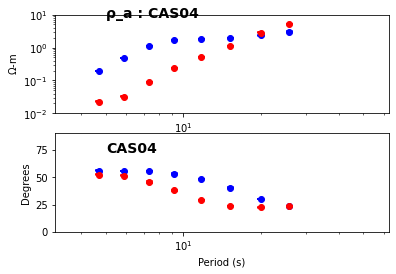

Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s


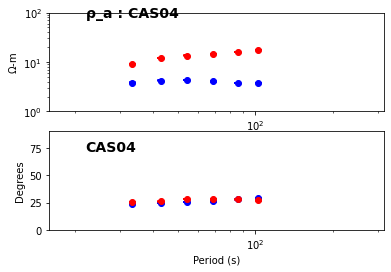

Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s


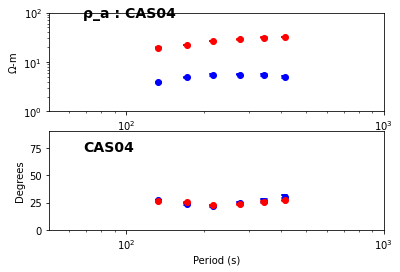

Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s


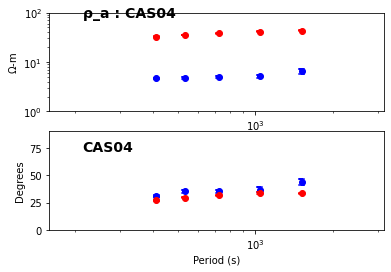

2022-09-09 02:23:49,478 [line 739] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/docs/examples/8P_CAS04.h5


In [34]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [35]:

type(tf_cls)

mt_metadata.transfer_functions.core.TF

Write the transfer functions generated by the Aurora pipeline

In [36]:
 tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="emtfxml")

2022-09-09 02:24:00,371 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [37]:
tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="edi")

2022-09-09 02:24:06,602 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [38]:
 tf_cls.write_tf_file(fn="emtfxml_test.xml", file_type="zmm")

2022-09-09 02:24:07,301 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote emtfxml_test.xml


EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)